# Optimizing Quantum Violations for the $I_{3322}$ Bell Inequality

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

from context import QNetOptimizer as QNopt

## Bipartite Non-Signaling Scenario

Consider the bipartite non-signaling scenario where Alice and Bob each have three classical inputs and two classical outputs.
This Bell scenario can be modeled as a prepare and measure network with a single preparation node and two measurement nodes, Alice and Bob.
The ansatz circuit for preparation and measurement is dictated by the local Hilbert space dimensions used by Alice and Bob and will not be specified until later.
For now, we'll use `network_ansatz` to refer to this bipartite non-signaling scenarios ansatz circuit.

## The $I_{3322}$ Bell Inequality

The Bell inequalities bounding this scenario are computed in full by [I. Pitowsky and K. Svozil](https://journals.aps.org/pra/).
It was later shown by [D. Collins and N. Gisin](https://iopscience.iop.org/article/10.1088/0305-4470/37/5/021/meta?casa_token=RZb3nMLhJIUAAAAA:gF2JkOypzzEwTxiTiC19UN3lBPUiq2MW0KB47JcD7LNh4GyoF2-dTE1YyB7qu9SWkg5sO1AoyfM) that there is one novel Bell inequality for this scenario, the $I_{3322}$ inequality.
For inputs $x,y\in \{0,1,2\}$ and outputs $a,b\in \{0,1\}$, the $I_{3322}$ Bell inequality is expressed as

\begin{align}
    I_{3322} := &-P_A(0|0) -2P_B(0|0) - P_B(0|1) + P(00|00) +P(00|01) + P(00|02) \\
    &+ P(00|10) + P(00|11) - p(00|12) + P(00|20) - P(00|21) 
\end{align}

The classical upper bound is $I_{3322} \leq \beta_C = 0$.
An interesting feature of this inequality is that the amount of quantum violation increases with larger entanglement Hilbert space dimensions.
Bounds for the infinite dimensional quantum case were produced by [K. Pal and T. Vertesi](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.82.022116) and found to be $I_{3322}\leq \beta_Q \leq 0.250\: 875\: 38$.

When the multi-qubit case is run as a quantum circuit, a measurement is applied to each local qubit resulting in an $2^N$ outcome measurement.
The $I_{3322}$ inequality is defined for dichotomic measurements, hence, the measurement results must be post-processed.
We'll express the probabilities for the $2^N$ outcome measurement as $P(\vec{a},\vec{b}|x,y)$ where $\vec{a}$ and $\vec{b}$ are each $N$-bit strings.
Post-processing is applied to $P(\vec{a},\vec{b}|x,y)$ to reduce them into joint probabilities of dichotomic observables $P(a,b|x,y)$.
The $I_{3322}$ inequality only requires dichotomic probabilities $P(00|xy)$ which are calculated as

$$
P(00|xy) = \{Even\}_A\{Even\}_B = \sum_{\vec{a}\in \{Even\}} \sum_{\vec{b}\in\{Even\}} P(\vec{a},\vec{b}|x,y)
$$

where $\vec{a} = a_0 a_1 a_2\dots$ and $\vec{b} = b_0 b_1 b_2 \dots$ are bit strings whose parity distinguishes them as belonging to the set of $Even$ or $Odd$ parity bitstrings.
For convenience we write functions to construct the set of ids for the even valued bitstrings in a vectors $\vec{a}$ or $\vec{b}$.

In [2]:
def parity_vector(n_qubits):
    """Constructs a vector with +/- 1 elements. (+) and (-) correspond to even and odd parity respectively."""
    if n_qubits == 1:
        return np.array([1, -1])
    
    return np.kron([1, -1], parity_vector(n_qubits - 1))

def even_parity_ids(n_qubits):
    """Collects the ids of the (+) elements in the parity_vector()"""
    p_vec = parity_vector(n_qubits)
    return np.argwhere(p_vec == 1).flatten()

def multi_qubit_I_3322_post_processing(n_qubits, probs_vec):
    """Applies the post-process to coarse-grain to a dichotomic measurement."""
    probs = np.reshape(probs_vec, (2**n_qubits, 2**n_qubits))
    
    ev_ids = even_parity_ids(n_qubits)
    
    return sum([ sum([probs[a,b] for b in ev_ids]) for a in ev_ids])

Next, we create constructors for general $I_{3322}$ qnodes and cost functions.

In [3]:
def _I_3322_local_observables(network_ansatz):
    """Construct list of local observables for Alice and Bob."""
    obs_list = []
    for node in network_ansatz.measure_nodes:
        obs = None
        for wire in node.wires:
            if obs == None:
                obs = qml.PauliZ(wire)
            else:
                obs = obs @ qml.PauliZ(wire)
        
        obs_list.append(obs)
    
    return obs_list

def _I_3322_local_expvals_qnode(network_ansatz):
    """Construct a qnode for computing local observable expectations."""
    observables = _I_3322_local_observables(network_ansatz)
    
    @qml.qnode(network_ansatz.dev)
    def circuit(prepare_settings, measure_settings):
        network_ansatz.fn(prepare_settings, measure_settings)
        
        return [qml.expval(obs) for obs in observables]
    
    return circuit

def _I_3322_joint_probs_qnode(network_ansatz):
    """Construct a qnode for computing joint probabilities in the computational basis."""
    @qml.qnode(network_ansatz.dev)
    def circuit(prepare_settings, measure_settings):
        network_ansatz.fn(prepare_settings, measure_settings)
        
        return qml.probs(wires=network_ansatz.measure_wires)
    
    return circuit

def _I_3322_expval_cost(network_ansatz):
    r"""Constructs a generic $I_{3322}$ cost function."""

    I_3322_joint_probs_qnode = _I_3322_joint_probs_qnode(network_ansatz) 
    local_expval_qnode = _I_3322_local_expvals_qnode(network_ansatz)
    
    def cost(scenario_settings):
        θ = network_ansatz.layer_settings(scenario_settings[0], [0])
        score = 0
   
        for (x, y, mult) in [(0,0,1),(0,1,1),(0,2,1),(1,0,1),(1,1,1),(1,2,-1),(2,0,1),(2,1,-1)]:
            ϕ = network_ansatz.layer_settings(scenario_settings[1], [x, y])
            
            probs_vec_xy = I_3322_joint_probs_qnode(θ, ϕ)
            prob00_xy = multi_qubit_I_3322_post_processing(len(network_ansatz.measure_wires)//2, probs_vec_xy)
    
            score += mult * prob00_xy

        ϕ_00 = network_ansatz.layer_settings(scenario_settings[1], [0,0])
        ϕ_11 = network_ansatz.layer_settings(scenario_settings[1], [1,1])
        
        expval_00 = local_expval_qnode(θ,ϕ_00)
        expval_11 = local_expval_qnode(θ,ϕ_11)

        # - P_A(0|0)
        score += -1 * (expval_00[0] + 1)/2

        # - 2 * P_B(0|0)
        score += -2 * (expval_00[1] + 1)/2

        # - P_B(0|1)
        score += -1 * (expval_11[1] + 1)/2

        return -(score)    

    return cost

## Qubit Case

Using an arbitrary qubit parameterization, the maximal violation is found to be close to 0.25 for local measurements on single qubits.

In [4]:
local_qubits = 1

prepare_nodes = [QNopt.PrepareNode(1,range(2*local_qubits),qml.templates.subroutines.ArbitraryUnitary, 4**(2*local_qubits)-1)]
measure_nodes = [
    QNopt.MeasureNode(3,2, [0], qml.templates.subroutines.ArbitraryUnitary, 4**(2*local_qubits//2) - 1),
    QNopt.MeasureNode(3,2, [1], qml.templates.subroutines.ArbitraryUnitary, 4**(2*local_qubits//2) - 1)
]

qubit_ansatz = QNopt.NetworkAnsatz(prepare_nodes, measure_nodes)

In [5]:
# perform gradient descent
init_settings = qubit_ansatz.rand_scenario_settings()
I_3322_cost = _I_3322_expval_cost(qubit_ansatz) 

opt_dict = QNopt.gradient_descent(I_3322_cost, init_settings, step_size = 0.2, num_steps=200)

iteration :  0 , score :  -0.5003337183486474
iteration :  25 , score :  0.14027235872102134
iteration :  50 , score :  0.23036546571232686
iteration :  75 , score :  0.2473426472520564
iteration :  100 , score :  0.24964192548143876
iteration :  125 , score :  0.2499501959133641
iteration :  150 , score :  0.24999294854974957
iteration :  175 , score :  0.2499989945091543


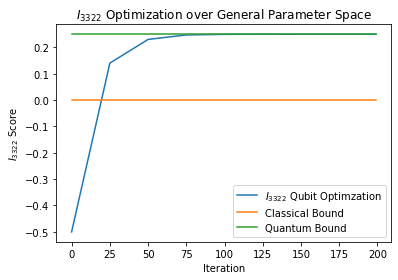

In [6]:
# Plot the score of the Bell throughout the optimization inequality
plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$ Qubit Optimzation")
plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound")
plt.title(r"$I_{3322}$ Optimization over General Parameter Space")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

## Multi-Qubit Case

In the multi-qubit case for the $I_{3322}$ inequality, Alice and Bob have have access to a larger shared Hilbert space.
This allows more flexibility in the entanglement shared between Alice and Bob.
We'll now show the $I_{3322}$ optimization over examples of different prepare and measure ansatzes.
We note that our optimizations can be run with relative efficiency for up to 10-qubits total.

### GHZ State Preparation and Local RY and RX Rotated Measurements

Here we investigate the case where Alice and Bob share a GHZ state prepared on $2N$-qubits where Alice and Bob each hold $N$ qubits locally.

In [7]:
def qubit_RXRY(settings, wires):        
    for i, wire in enumerate(wires):
        qml.RY(settings[2*i], wires=wire)
        qml.RX(settings[2*i + 1], wires=wire) 

np.random.seed(1)
sampled_optimizations = []
for n_local_qubits in range(1,6):
    ghz_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),QNopt.ghz_state_preparation, 0)]
    local_rxry_measure_nodes = [
        QNopt.MeasureNode(3,2, range(n_local_qubits), qubit_RXRY, 2*n_local_qubits),
        QNopt.MeasureNode(3,2, range(n_local_qubits, 2*n_local_qubits), qubit_RXRY, 2*n_local_qubits)
    ]

    ghz_local_rxry_ansatz = QNopt.NetworkAnsatz(ghz_prepare_nodes, local_rxry_measure_nodes)
    
    opt_dict = {"opt_score" : 0}
    while opt_dict["opt_score"] < 0.24:
        print("n_local_qubits : ", n_local_qubits)
        ghz_local_rxry_settings = ghz_local_rxry_ansatz.rand_scenario_settings()
        I_3322_cost_ghz_local_rxry = _I_3322_expval_cost(ghz_local_rxry_ansatz) 
    
        start = time.time()
        opt_dict = QNopt.gradient_descent(I_3322_cost_ghz_local_rxry, ghz_local_rxry_settings, step_size = 0.15, num_steps=300)
        stop = time.time()
        print("opt_score : ", opt_dict["opt_score"])
        print("elapsed time : ", stop - start)

        
    sampled_optimizations.append(opt_dict)    

n_local_qubits :  1
iteration :  0 , score :  -1.6488366728736694
iteration :  25 , score :  0.016563615301259382
iteration :  50 , score :  0.23391841134096625
iteration :  75 , score :  0.24843747557238993
iteration :  100 , score :  0.24981301234280728
iteration :  125 , score :  0.24997404095555886
iteration :  150 , score :  0.2499958931690216
iteration :  175 , score :  0.24999926854986398
iteration :  200 , score :  0.24999985667718638
iteration :  225 , score :  0.2499999699968214
iteration :  250 , score :  0.24999999345912371
iteration :  275 , score :  0.24999999854093824
opt_score :  0.24999999967047204
elapsed time :  11.735491752624512
n_local_qubits :  2
iteration :  0 , score :  -0.7583779879630907
iteration :  25 , score :  -0.052461749449583706
iteration :  50 , score :  0.14777898826857983
iteration :  75 , score :  0.18365798472315759
iteration :  100 , score :  0.19728463198368446
iteration :  125 , score :  0.2034653366247926
iteration :  150 , score :  0.20585390

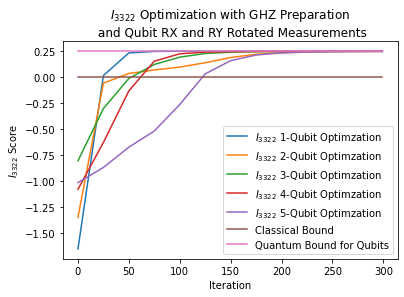

In [8]:
for i, opt_dict in enumerate(sampled_optimizations):
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$" + f" {i+1}-Qubit Optimzation")
    
plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound for Qubits")
plt.title(r"$I_{3322}$ Optimization with GHZ Preparation" +  "\n and Qubit RX and RY Rotated Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Bell State Copy Preparations

An alternative state preparation is when Alice and Bob share $N$ entangled Bell pairs.
An interesting observation is that for this case, the quantum violation of $0.25$ can be obtained using only RY rotations on each measured qubit wire.

In [9]:
def bell_state_copies(settings, wires):        
    for i in range(len(wires)//2):
        qml.Hadamard(wires=wires[i])
        qml.CNOT(wires=[wires[i],wires[i+len(wires)//2]])

def qubit_RY(settings, wires):        
    for i, wire in enumerate(wires):
        qml.RY(settings[i], wires=wire)

bell_copies_optimizations = []
for n_local_qubits in range(1,6):
    bell_copies_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),bell_state_copies, 0)]
    local_rxry_measure_nodes = [
        QNopt.MeasureNode(3,2, range(n_local_qubits), qubit_RY, n_local_qubits),
        QNopt.MeasureNode(3,2, range(n_local_qubits, 2*n_local_qubits), qubit_RY, n_local_qubits)
    ]

    bell_copies_local_rxry_ansatz = QNopt.NetworkAnsatz(bell_copies_prepare_nodes, local_rxry_measure_nodes)
    
    opt_dict = {"opt_score" : 0}
    while opt_dict["opt_score"] < 0.24:
        print("n_local_qubits : ", n_local_qubits)
        bell_copies_local_rxry_settings = bell_copies_local_rxry_ansatz.rand_scenario_settings()
        I_3322_cost_bell_copies_local_rxry = _I_3322_expval_cost(bell_copies_local_rxry_ansatz) 
        
        start = time.time()
        opt_dict = QNopt.gradient_descent(I_3322_cost_bell_copies_local_rxry, bell_copies_local_rxry_settings, step_size = 0.15, num_steps=300)
        stop = time.time()
        print("opt_score : ", opt_dict["opt_score"])
        print("elapsed time : ", stop - start)
        
    bell_copies_optimizations.append(opt_dict)    

n_local_qubits :  1
iteration :  0 , score :  -1.4015336544356836
iteration :  25 , score :  0.14154208187191752
iteration :  50 , score :  0.24581708179328565
iteration :  75 , score :  0.24968565345505978
iteration :  100 , score :  0.24996509311020487
iteration :  125 , score :  0.2499943411214267
iteration :  150 , score :  0.24999889449202817
iteration :  175 , score :  0.24999977054475364
iteration :  200 , score :  0.2499999515737681
iteration :  225 , score :  0.2499999897348597
iteration :  250 , score :  0.2499999978215781
iteration :  275 , score :  0.24999999953756902
opt_score :  0.2499999999018283
elapsed time :  7.451910972595215
n_local_qubits :  2
iteration :  0 , score :  -1.0430611532845053
iteration :  25 , score :  0.020945306306206835
iteration :  50 , score :  0.10994219375978176
iteration :  75 , score :  0.12365907392677178
iteration :  100 , score :  0.12490872916365037
iteration :  125 , score :  0.12501158571759952
iteration :  150 , score :  0.1250312393831

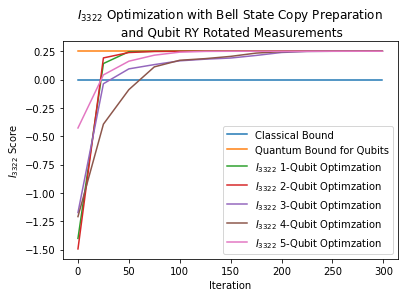

In [10]:
for i, opt_dict in enumerate(bell_copies_optimizations):
    if i == 0:
        plt.plot(opt_dict["samples"], [0]*len(opt_dict["samples"]), label = "Classical Bound")
        plt.plot(opt_dict["samples"], [0.25]*len(opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"$I_{3322}$" + f" {i+1}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with Bell State Copy Preparation" +  "\n and Qubit RY Rotated Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Two-Qubit Case GHZ State and Arbitrary Measurements

In [11]:
n_local_qubits = 2

ghz_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),QNopt.ghz_state_preparation, 0)]
arb_measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1),
    QNopt.MeasureNode(3,2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1)
]

ghz_arb_ansatz = QNopt.NetworkAnsatz(ghz_prepare_nodes, arb_measure_nodes)

In [12]:
%%time

np.random.seed(1)  # optimization is susceptible to local optima, fixing initial conditions for good example
ghz_arb_settings = ghz_arb_ansatz.rand_scenario_settings()
I_3322_cost_ghz_arb = _I_3322_expval_cost(ghz_arb_ansatz) 

ghz_arb_opt_dict = QNopt.gradient_descent(I_3322_cost_ghz_arb, ghz_arb_settings, step_size = 0.2, num_steps=250)

iteration :  0 , score :  -0.9393187059336029
iteration :  25 , score :  0.06537843333167537
iteration :  50 , score :  0.1442417563397807
iteration :  75 , score :  0.20303775415459235
iteration :  100 , score :  0.23126883329333203
iteration :  125 , score :  0.24051605759639116
iteration :  150 , score :  0.24432032256395758
iteration :  175 , score :  0.24629945065593695
iteration :  200 , score :  0.24746686664992568
iteration :  225 , score :  0.24820062861559278
CPU times: user 1min 4s, sys: 417 ms, total: 1min 4s
Wall time: 1min 5s


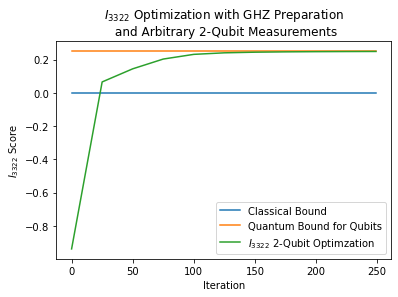

In [13]:
plt.plot(ghz_arb_opt_dict["samples"], [0]*len(ghz_arb_opt_dict["samples"]), label = "Classical Bound")
plt.plot(ghz_arb_opt_dict["samples"], [0.25]*len(ghz_arb_opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
plt.plot(ghz_arb_opt_dict["samples"], ghz_arb_opt_dict["scores"], label = r"$I_{3322}$" + f" {2}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with GHZ Preparation" +  "\n and Arbitrary 2-Qubit Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

### Two-Qubit Case Bell Copy Preparation and Arbitrary Measurement

In [14]:
n_local_qubits = 2

bell_copy_prepare_nodes = [QNopt.PrepareNode(1,range(2*n_local_qubits),bell_state_copies, 0)]
arb_measure_nodes = [
    QNopt.MeasureNode(3,2, [0,1], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1),
    QNopt.MeasureNode(3,2, [2,3], qml.templates.subroutines.ArbitraryUnitary, 4**(n_local_qubits) - 1)
]

bell_copy_arb_ansatz = QNopt.NetworkAnsatz(bell_copy_prepare_nodes, arb_measure_nodes)

In [15]:
%%time

bell_copy_arb_settings = bell_copy_arb_ansatz.rand_scenario_settings()
I_3322_cost_bell_copy_arb = _I_3322_expval_cost(bell_copy_arb_ansatz) 

bell_copy_arb_opt_dict = QNopt.gradient_descent(I_3322_cost_bell_copy_arb, bell_copy_arb_settings, step_size = 0.2, num_steps=250)

iteration :  0 , score :  -0.9803150968491762
iteration :  25 , score :  0.09801141465695173
iteration :  50 , score :  0.2010958938548597
iteration :  75 , score :  0.23255446831454307
iteration :  100 , score :  0.24290677862809656
iteration :  125 , score :  0.24700681732690621
iteration :  150 , score :  0.2487592269870535
iteration :  175 , score :  0.2494967660853583
iteration :  200 , score :  0.24979768846149353
iteration :  225 , score :  0.2499181395987533
CPU times: user 1min 3s, sys: 375 ms, total: 1min 3s
Wall time: 1min 4s


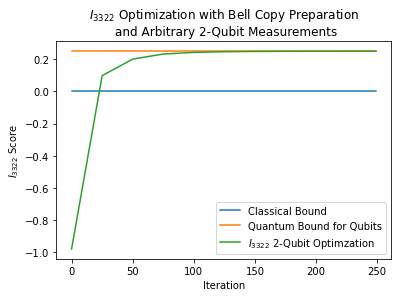

In [16]:
plt.plot(bell_copy_arb_opt_dict["samples"], [0]*len(bell_copy_arb_opt_dict["samples"]), label = "Classical Bound")
plt.plot(bell_copy_arb_opt_dict["samples"], [0.25]*len(bell_copy_arb_opt_dict["samples"]), label = "Quantum Bound for Qubits")
    
plt.plot(bell_copy_arb_opt_dict["samples"], bell_copy_arb_opt_dict["scores"], label = r"$I_{3322}$" + f" {2}-Qubit Optimzation")
    
plt.title(r"$I_{3322}$ Optimization with Bell Copy Preparation" +  "\n and Arbitrary 2-Qubit Measurements")
plt.xlabel("Iteration")
plt.ylabel(r"$I_{3322}$ Score")
plt.legend()
plt.show()

## Scratchwork